In [105]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

### Exploring the data

In [29]:
# checking for null values in the dataset
display(arrests.isnull().sum())

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

No null values identified in the data - no need for imputation

In [30]:
# displaying general information regarding the dataset
arrests = pd.read_csv('UsArrests.csv')
display(arrests.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


None

In [31]:
# assessing the statistical properties of the data
display(arrests.describe().loc[['mean', 'std', 'min', 'max'], :].transpose())

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


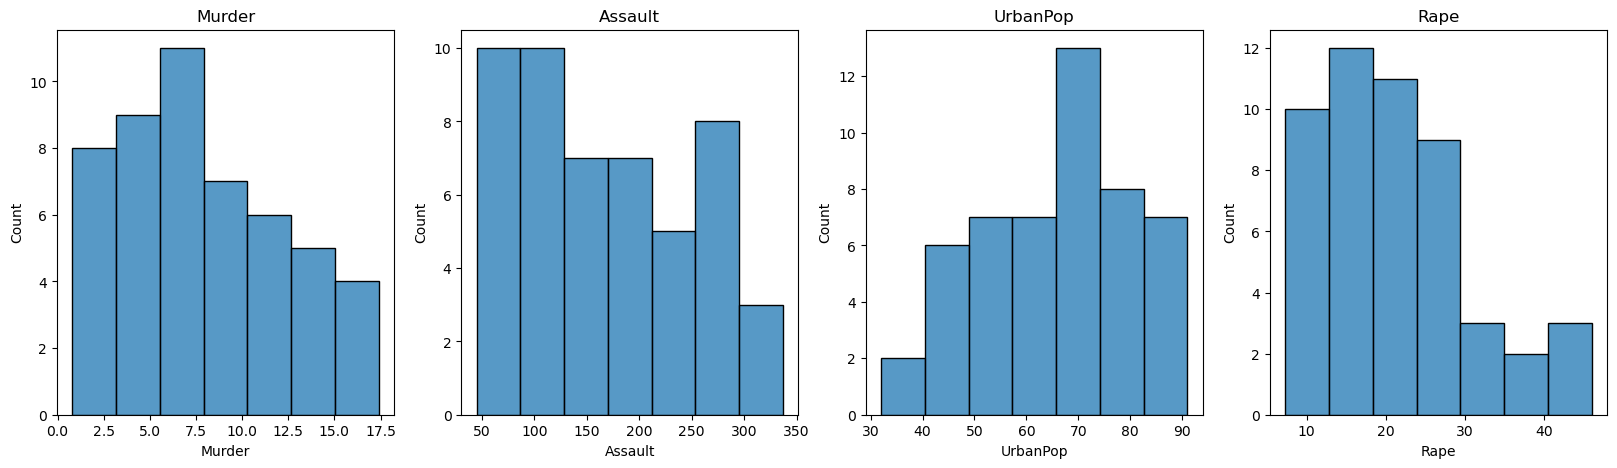

In [27]:
# plotting histograms of the data
fig, ax = plt.subplots(1,4, figsize = (20, 5))
for index, i in enumerate(arrests.columns.values[1:]):
    sns.histplot(data = arrests, x = i, ax = ax[index])
    ax[index].set_title(i)

### Analysing Correlations

<AxesSubplot:>

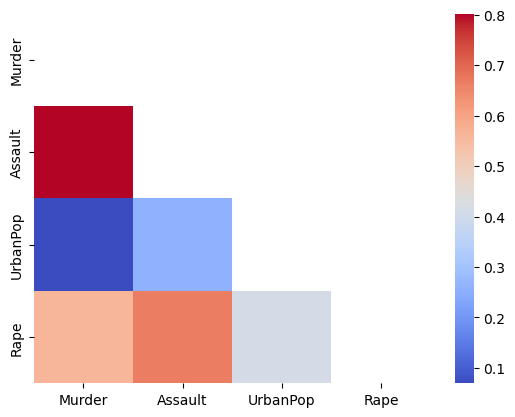

In [50]:
# isolating the variables of interest and standardising the data
X = arrests.iloc[:,1:]
columns = arrests.columns.values[1:]
X_std = pd.DataFrame(StandardScaler().fit_transform(X), columns = columns)

# generating a correlation heatmap
corr_df = X_std.corr()
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask = mask_ut, cmap="coolwarm")

The correlation heatmap shows that there are correlations between the rates of violent crime, with a strong correlation between murder and assualt, and weaker corelations between rape and assualt, and rape and murder. The proportion of the population living in areas is not correlated with the other variables. This suggests that 2 principal components would likely explain most of the variance in the data (one that would correlate with the rates of violent crime, another that would correlate with the urban population percentage), although as rape is not as strongly correlated with the other crime variables, a third principal component may also prove useful

### Principal Component Analysis

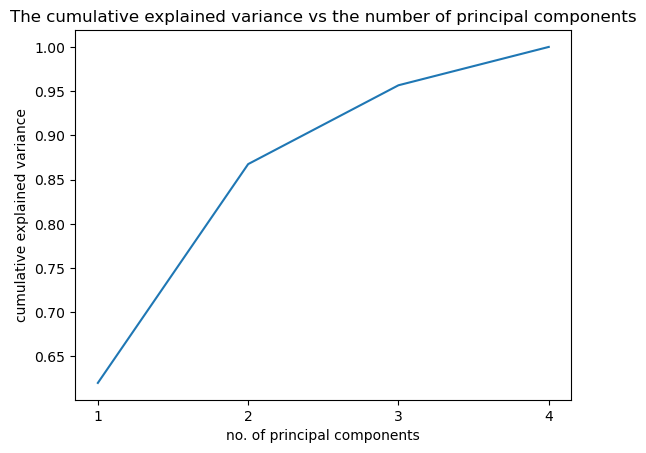

In [136]:
# performing principal component analysis on the standardised data
pca = PCA(4)
pca_std_df = pca.fit_transform(X_std.values)

# analysing the variance explained by each principal component
explained_variances = pca.explained_variance_ratio_
sns.lineplot(x = range(1,5), y = np.cumsum(explained_variances)) 
plt.xticks(range(1,5))
plt.xlabel('no. of principal components')
plt.ylabel('cumulative explained variance')
plt.title('The cumulative explained variance vs the number of principal components')
plt.show()

The plot shows that almost 60% of the variance is explained by one principal component, which is likely related to the rates of violent crime. Adding a second component significantly increases the explained variance. Adding a 3rd and 4th principal component does not increase the explained variance as significantly. This is explored in more detail below.

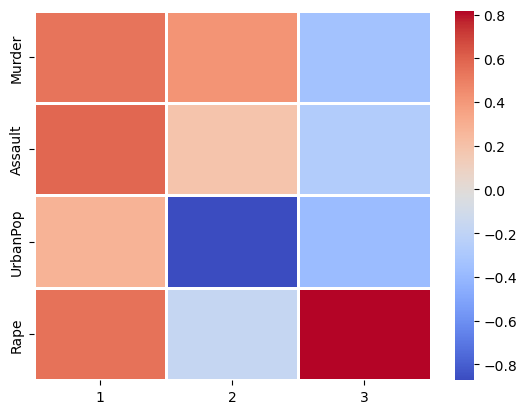

In [199]:
# performing principal component analysis with 3 components
pca = PCA(3)
pca_std_df = pca.fit_transform(X_std.values)

# generating a correlation heatmap between the principal components and the original variables
components = pd.DataFrame(pca.components_, columns=arrests.iloc[:,1:].columns, index=range(1, 4)).transpose()
ax = sns.heatmap(components,cmap = "coolwarm",linewidth=1)
plt.show()

As expected, this correlation heatmap suggests that the first principal component is strongly correlated with the rates of violent crime. The second principal component accounts for the urban population percentage, and a third is strongly correlated with the rape rates

In [200]:
# displaying the importance of each feature in the data to each of the principal components
feature_importance = {}
for i in range(0,3):
    feature_importance[f"Component {i+1}"] = pca.components_[i]

feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient = 'index', columns = columns)
pd.options.display.float_format = "{:,.2f}".format
display(feature_importance_df)

,Murder,Assault,UrbanPop,Rape
Component 1,0.54,0.58,0.28,0.54
Component 2,0.42,0.19,-0.87,-0.17
Component 3,-0.34,-0.27,-0.38,0.82


This table shows that component 1 is most strongly influenced by the rates of violent crime. Component 2 is mostly influenced by the urban population percentage. Component 3 is mostly influenced by the rates of rape. Component 4 is mostly influenced by the rates of murder and assualt

Based on all of the analyses above, and the fact that the 3 principal components explain 95% of the total variance, 3 principal components can be used to perform cluster analyses, rather than using the original 4 variables

In [194]:
# creating a dataframe with the principal components of each value
pca_std_df_3 = pd.DataFrame(pca_std_df[:, 0:3], index = arrests.index, columns = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3']) # isolating the 3 principal components for cluster analysis

### Cluster analysis

#### Kmeans clustering

Text(0, 0.5, 'principal component 2')

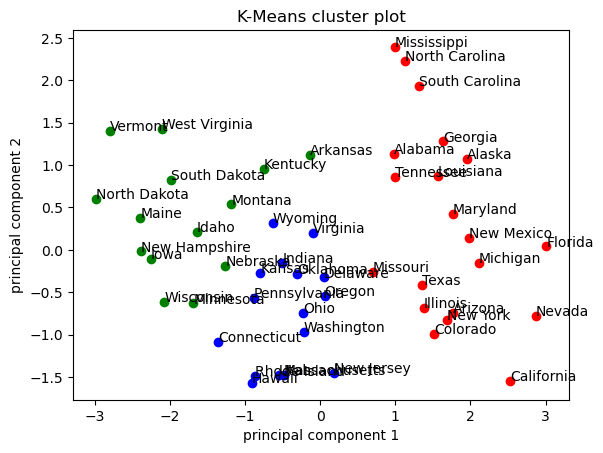

In [197]:
k = 3 # defining the number of clusters. 
# 3 clusters are used as 3 principal components have been used in the pca model.

# creating the k means cluster model
kmeans = KMeans(n_clusters = k, random_state = 2)
cluster_labels = kmeans.fit_predict(pca_std_df_3)
cent = kmeans.cluster_centers_

# Plot clusters
x = pca_std_df[:, 0]
y = pca_std_df[:, 1]
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
    txt = arrests['City'][i]
    ax.annotate(txt, (x[i], y[i]))
    
ax.set_title("K-Means cluster plot")
ax.set_xlabel("principal component 1")
ax.set_ylabel("principal component 2")

The K means cluster plot with 3 clusters creates 3 distinct groups of cities: 
1) those with a high principal component 1 (i.e high violent crime rates) - coloured in red 
<br>
2) those with a low principal component 2 (i.e high urban population) and relatively low principal component 1 (i.e low violent crime rate) - coloured in green
<br>
3) those with a high principal component 2 (i.e low urban population) and a low principal component 1 (i.e low crime rate) - coloured in blue

Principal component 3 does not significantly influence the clustering as shown by the plot below. 

Text(0, 0.5, 'principal component 3')

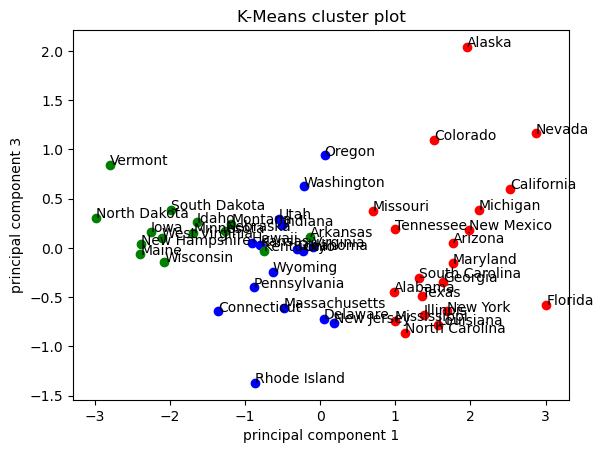

In [198]:
x = pca_std_df[:, 0]
y = pca_std_df[:, 2]
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
    txt = arrests['City'][i]
    ax.annotate(txt, (x[i], y[i]))
    
ax.set_title("K-Means cluster plot")
ax.set_xlabel("principal component 1")
ax.set_ylabel("principal component 3")

#### Hierachical clustering

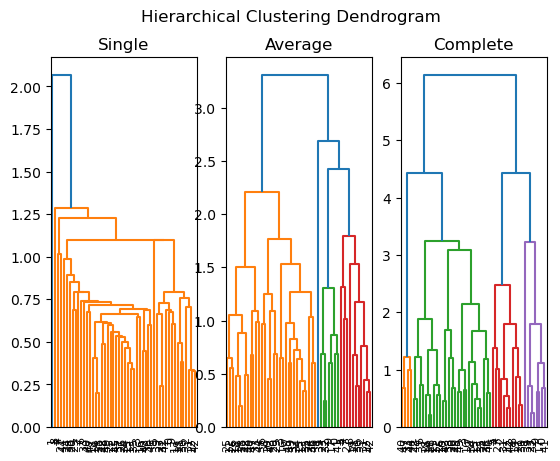

In [195]:
# implementing an agglomerative clustering model on the data analysed using PCA
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(pca_std_df_3)

# plotting the hierachical clustering dendrograms created using different methods
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_std_df_3, method='single'), labels=pca_std_df_3.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_std_df_3, method='average'), labels=pca_std_df_3.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_std_df_3, method='complete'), labels=pca_std_df_3.index, ax=ax3)
plt.show()

The hierachical clustering dendrogram created using the complete method provides the most balanced dispersion of clusters with 4 clear clusters identified. 4 clusters were therefore used for the final agglomerative clustering model

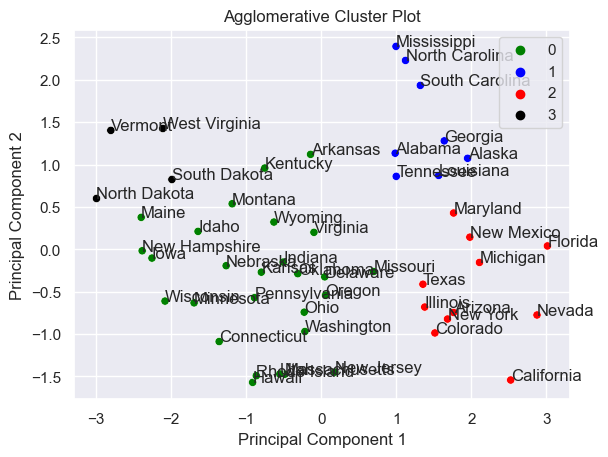

In [208]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
cluster.fit(pca_std_df_3)
sns.scatterplot(data = pca_std_df_3, x = 'Principal Component 1', y = 'Principal Component 2', hue = cluster.labels_, palette = ['green', 'blue', 'red', 'black'])
for i in range(0,len(pca_std_df_3)):
    txt = arrests['City'][i]
    plt.annotate(txt, (x[i], y[i]))

plt.title('Agglomerative Cluster Plot')
plt.show()

The final model divides the data into 4 distinct groups of cities:
<br>
1) those with a high principal component 1 (i.e high violent crime rates) and low principal component 2 (i.e high urban population - coloured in red 
<br>
2) those with a high principal component 1 (i.e high urban population) and high principal component 2 (i.e low urban population) - coloured in blue
<br>
3) those with a low principal component 1 (i.e low violent crime rate) and a low principal component 2 (i.e high urban population) - coloured in green
<br>
4) those with a low principal component 1 (i.e low violent crime rate) and a high principal component 2 (i.e low urban population) - coloured in black